In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import h5py
import natsort

In [3]:
#name = 'Data/results_widebnet_10squares.h5'
#name = 'results_diffusion_uncompressed_squares.h5'
#name = 'results_diffusion_analytical_squares.h5'
#name = 'results_diffusion_uncompressed_3510tri.h5'
#name = 'Data/results_switchnet_10squares.h5'
#name = 'Data/results_compressed_10squares.h5'
#name = 'results_diffusion_squares_freq_2.5_5_10.hdf5'
#name = 'results_diffusion_squares_freq_2.5.hdf5'
#name = 'results_diffusion_3510tri_freq_2.5_5_10.hdf5'
#name = 'results_diffusion_3510tri_freq_2.5.hdf5'
#name = 'results_diffusion_shepplogan_freq_2.5_5_10.hdf5'
#name = 'results_diffusion_shepplogan_freq_2.5.hdf5'
#name = 'results_diffusion_widebnet_3510tri_freq_2.5_5_10.hdf5'
#name = 'results_diffusion_uncompressed_shepp_logan_2.h5'
#name = 'results_diffusion_squares_freq_2.5_5_10.hdf5'
#name = 'results_diffusion_uncompressed_square_high_freq.h5'
#name = 'results_diffusion_compressed_squares.h5'
#name = 'results_diffusion_switchnet_squares.h5'
name = 'results_diffusion_uncompressed_squares_final.h5'

# Loading truth eta
with h5py.File(f'{name}', 'r') as f:
    #print("Keys: %s" % f.keys())
    eta_re = f['eta'][()]

# Loading predicted eta
with h5py.File(f'{name}', 'r') as f:
    eta_re_pred = f['eta_pred'][()]

# Clean up temporary variables to free memory
#del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [4]:
eta_re.shape

(2000, 80, 80, 1)

In [5]:
eta_re_pred.shape

(2000, 4, 80, 80, 1)

In [6]:
errors = []
for i in range(2000):
    errors.append(np.linalg.norm(eta_re[i,:,:,:]-eta_re_pred[i,2,:,:,:])/np.linalg.norm(eta_re[i,:,:,:]))

In [24]:
np.min(errors)

0.00695084625759072

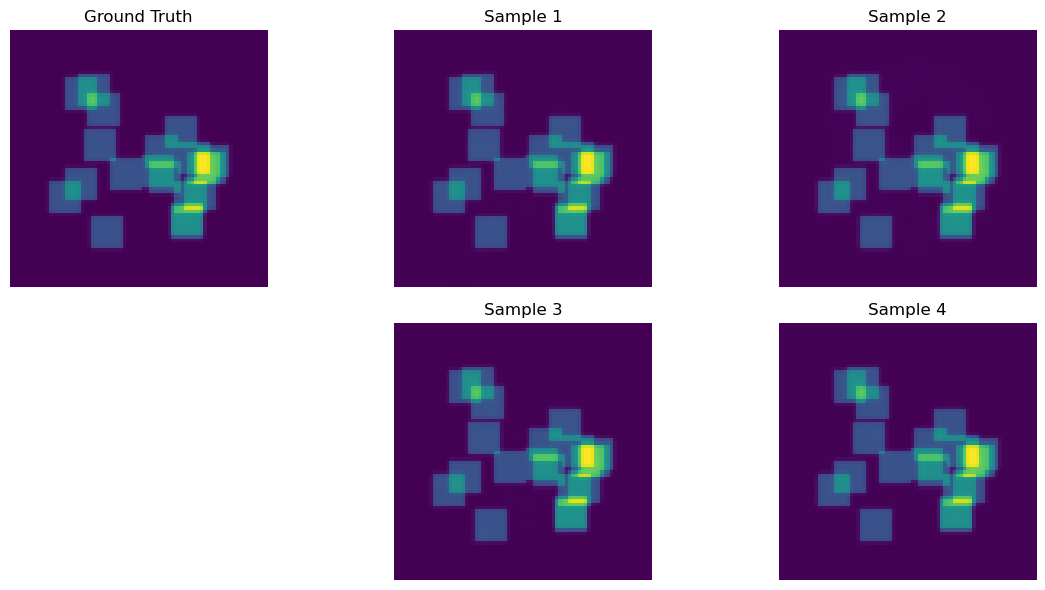

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming ground_truth and samples are already loaded as NumPy arrays
# Example initialization (replace with your actual image arrays)
# ground_truth = np.random.rand(256, 256, 3)  # Example ground truth image
# samples = [np.random.rand(128, 128, 3) for _ in range(4)]  # Example smaller sample images

# Plotting
fig = plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Add ground truth plot
ax1 = fig.add_subplot(2, 3, 1)  # 2 rows, 3 columns, 1st position spans all rows
ax1.imshow(eta_re[0,:,:,0])
ax1.set_title('Ground Truth')
ax1.axis('off')  # Hide axes

ax2 = fig.add_subplot(2, 3, 2)  # 2 rows, 3 columns, start placing at 3rd position
ax2.imshow(eta_re_pred[0,0,:,:,0])
ax2.set_title('Sample 1')
ax2.axis('off')  # Hide axes
ax2 = fig.add_subplot(2, 3, 3)  # 2 rows, 3 columns, start placing at 3rd position
ax2.imshow(eta_re_pred[0,1,:,:,0])
ax2.set_title('Sample 2')
ax2.axis('off')  # Hide axes
ax2 = fig.add_subplot(2, 3, 5)  # 2 rows, 3 columns, start placing at 3rd position
ax2.imshow(eta_re_pred[0,2,:,:,0])
ax2.set_title('Sample 3')
ax2.axis('off')  # Hide axes
ax2 = fig.add_subplot(2, 3, 6)  # 2 rows, 3 columns, start placing at 3rd position
ax2.imshow(eta_re_pred[0,3,:,:,0])
ax2.set_title('Sample 4')
ax2.axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout so that plots are not overlapping
plt.show()
#fig.savefig("analytical_squares.jpg")

## CRPS

### For probabilistic

In [9]:
from swirl_dynamics.lib import metrics

In [10]:
cond_samples_metric = np.swapaxes(np.swapaxes(eta_re_pred[:,:,:,:,0],1,2),2,3)

In [11]:
cond_samples_metric.shape

(2000, 80, 80, 4)

In [12]:
crpss_1 = np.zeros((cond_samples_metric.shape[0],80,80))
for i in range(cond_samples_metric.shape[0]):
    crpss_1[i,:,:] = metrics.probabilistic_forecast.crps(cond_samples_metric[i,:,:,:], eta_re[i, :, :, 0], ensemble_axis=-1)

2024-05-16 10:53:35.423401: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


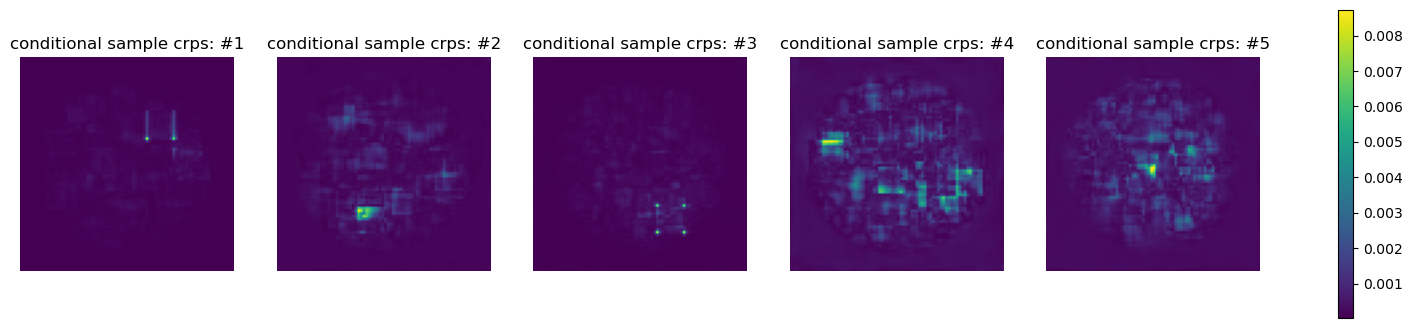

In [13]:
fig, axs = plt.subplots(1,5,figsize=(5*4, 4))
for i in range(5):
    im = axs[i].imshow(crpss_1[i+22, :, :])#, vmin=-2.5, vmax=2.5)
    axs[i].set_title(f"conditional sample crps: #{i + 1}")
    axs[i].axis("off")
fig.colorbar(im,ax=axs[:], location="right")
#plt.tight_layout()
plt.show()
#fig.savefig("squares_analytical.jpg")

In [14]:
#### computing the \ell^1 metric
crpss_11 = np.zeros(cond_samples_metric.shape[0])
for i in range(cond_samples_metric.shape[0]):
    crpss_11[i] = np.sum(np.abs(crpss_1[i,:,:]))/(80*80)

In [15]:
print('CRPS = %.8f' % np.mean(crpss_11))

CRPS = 0.00062426


## Energy Spectrum

In [25]:
from pysteps.utils.spectral import rapsd

### For deterministic

In [17]:
rapsds_ref = np.zeros((eta_re.shape[0], 40))
rapsds = np.zeros((eta_re.shape[0],40))
rapsds_error_ = np.zeros(eta_re.shape[0])
for i in range(eta_re.shape[0]):
    rapsds_ref[i,:] = rapsd(eta_re[i,:,:],fft_method=np.fft)
    rapsds[i,:] = rapsd(eta_re_pred[i,:,:],fft_method=np.fft)

ValueError: 3 dimensions are found, but the number of dimensions should be 2

In [18]:
np.mean(np.abs(np.log(rapsds/rapsds_ref)))

nan

In [15]:
rapsds_error_ = np.abs(np.log(np.mean(rapsds,axis=0)/np.mean(rapsds_ref,axis=0)))

In [16]:
print('radially averaged power spectrum = %.5f' % np.mean(rapsds_error_))

radially averaged power spectrum = 0.00176


### For probabilistic

In [26]:
rapsds = np.zeros((cond_samples_metric.shape[0], cond_samples_metric.shape[-1], 40))
rapsds_ref = np.zeros((cond_samples_metric.shape[0], 40))
rapsds_mean = np.zeros((cond_samples_metric.shape[0],40))
for i in range(cond_samples_metric.shape[0]):
    rapsds_ref[i,:] = rapsd(eta_re[i,:,:,0],fft_method=np.fft)
    for j in range(cond_samples_metric.shape[-1]):
        rapsds[i,j,:] = rapsd(cond_samples_metric[i,:,:,j],fft_method=np.fft)
    rapsds_mean[i,:] = np.mean(rapsds[i,:,:],axis=0)

In [27]:
rapsds_error_ = np.abs(np.log(rapsds_mean/rapsds_ref))

In [28]:
print('radially averaged power spectrum = %.5f' % np.mean(rapsds_error_))

radially averaged power spectrum = 0.01702


## Sinkhorn

In [56]:
#import importlib
#importlib.reload(ott)

In [29]:
import ott
from ott import problems
from ott.geometry import costs, pointcloud
from ott.solvers import linear
from ott.problems.linear import linear_problem
from ott.solvers.linear import acceleration, sinkhorn
from ott.tools.sinkhorn_divergence import sinkhorn_divergence

from scipy.ndimage import gaussian_filter

### For deterministic

In [23]:
eta_re_vect = eta_re[:,:,:].reshape((eta_re.shape[0],80*80))
eta_re_pred_vect = eta_re_pred[:,:,:].reshape((eta_re_pred.shape[0],80*80))

ValueError: cannot reshape array of size 51200000 into shape (2000,6400)

In [ ]:
geom = pointcloud.PointCloud(eta_re_vect[0,:], eta_re_pred_vect[0,:], cost_fn=costs.Euclidean())

In [23]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom)
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
# Solve OT problem
ot = solver(ot_prob)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.0009991394 
 Sinkhorn required  12  iterations to converge. 
 Entropy regularized OT cost:  0.008504147 
 OT cost (without entropy):  0.0030297337


### For probabilistic

In [30]:
# Parameters for the computational task.

L = 4 # number of levels (even number)
s = 5 # leaf size
r = 3 # rank

# Discretization of Omega (n_eta * n_eta).
neta = (2**L)*s

# Number of sources/detectors (n_sc).
# Discretization of the domain of alpha in polar coordinates (n_theta * n_rho).
# For simplicity, these values are set equal (n_sc = n_theta = n_rho), facilitating computation.
nx = (2**L)*s

# Standard deviation for the Gaussian blur.
blur_sigma = 0.5

# Number of training datapoints.
NTRAIN = 21000

In [31]:
#name = 'Data/traindata_smooth_sigma_0.04'
#name = 'Data/traindata_shepp_logan'
name = '../data/10squares'
#name = 'Data/traindata_3510tri'


# Loading and preprocessing perturbation data (eta)
with h5py.File(f'{name}/eta.h5', 'r') as f:
    # Read eta data, apply Gaussian blur, and reshape
    eta_re_train = f[list(f.keys())[0]][:NTRAIN, :].reshape(-1, neta, neta)
    blur_fn = lambda x: gaussian_filter(x, sigma=blur_sigma)
    eta_re_train = np.stack([blur_fn(eta_re_train[i, :, :]) for i in range(NTRAIN)]).astype('float32')

# Clean up temporary variables to free memory
#del scatter_re, scatter_im, tmp1, tmp2, tmp3

In [32]:
eta_re_train.shape

(21000, 80, 80)

In [33]:
num_samples_metric = 100

In [34]:
eta_re_pred.shape

(2000, 4, 80, 80, 1)

In [35]:
samples_theta = np.zeros((num_samples_metric*eta_re_pred.shape[1],80*80))
samples_test = np.zeros((num_samples_metric*eta_re_pred.shape[1],80*80))
samples_training = np.zeros((NTRAIN,80*80))
samples_theta[:,:] = eta_re_pred[:num_samples_metric,:,:,:,0].reshape((num_samples_metric*eta_re_pred.shape[1],80*80))
samples_test[:,:] = eta_re[:num_samples_metric*eta_re_pred.shape[1],:,:,0].reshape(num_samples_metric*eta_re_pred.shape[1],80*80)
samples_training[:,:] = eta_re_train[:,:,:].reshape(NTRAIN,80*80)

In [36]:
ot_ref = []
ot_test = []
# Create a Sinkhorn solver
solver = sinkhorn.Sinkhorn()
print(num_samples_metric*eta_re_pred.shape[1]+1)
for i in range(1,num_samples_metric*eta_re_pred.shape[1]+1):
    print(i)
    #geom_1 = pointcloud.PointCloud(samples_training[:i,:], samples_test[:i,:], cost_fn=costs.Euclidean())
    geom_2 = pointcloud.PointCloud(samples_theta[:i,:], samples_test[:i,:], cost_fn=costs.Euclidean())
    # Define a linear problem with that cost structure.
    #ot_prob_ref = linear_problem.LinearProblem(geom_1)
    ot_prob_test = linear_problem.LinearProblem(geom_2)
    # Solve OT problem
    #ot_1 = solver(ot_prob_ref)
    ot_2 = solver(ot_prob_test)
    #ot_ref.append(ot_1.reg_ot_cost)
    ot_test.append(ot_2.reg_ot_cost)

401
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [23]:
len(ot_test)

400

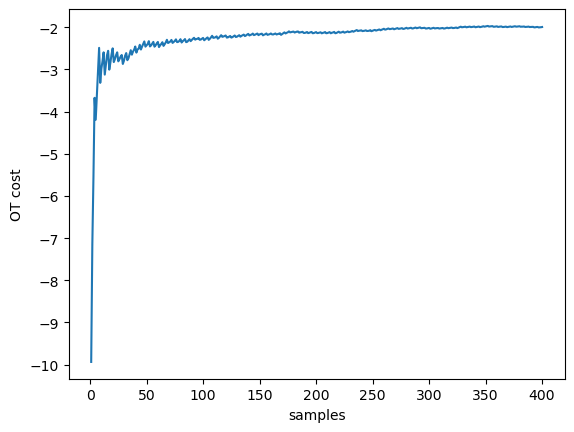

In [24]:
plt.plot(range(1,len(ot_test)+1), np.array(ot_test) - np.array(ot_ref))
#plt.yscale('log')
plt.ylabel('OT cost')
plt.xlabel('samples')
#plt.savefig('sinkhorn_smooth_sigma_0.04_comparison_abs.png')
plt.show()

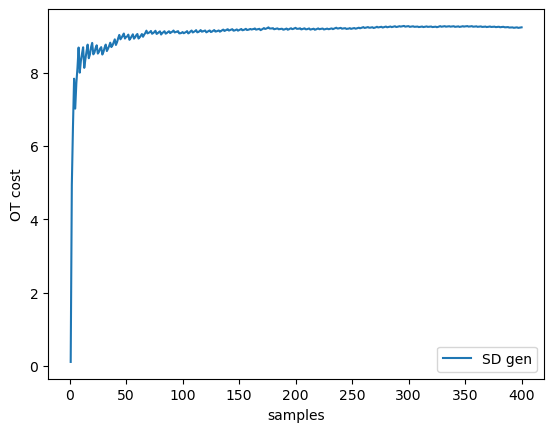

In [25]:
#plt.plot(range(1,len(ot_test)+1), np.array(ot_ref), label="SD ref")
plt.plot(range(1,len(ot_test)+1), np.array(ot_test), label="SD gen")
#plt.yscale('log')
plt.ylabel('OT cost')
plt.xlabel('samples')
plt.legend()
#plt.savefig('sinkhorn_smooth_sigma_0.04.png')
plt.show()

In [26]:
print('Sinkhorn divergence ref = %.5f' % ot_ref[len(ot_test)-1])

Sinkhorn divergence ref = 11.22465


In [37]:
print('Sinkhorn divergence test = %.5f' % ot_test[len(ot_test)-1])

Sinkhorn divergence test = 9.23519


In [28]:
print('|ref-test| = %.5f' % abs(ot_ref[len(ot_test)-1] - ot_test[len(ot_test)-1]))

|ref-test| = 1.99331
